# Introduction

This notebooks presents **ConvNet** in PyTorch used to solve **Street View House Numbers** task.

This is replication of _Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks_

**Contents**
* [Imports](#Imports)
* [Dataset](#Dataset)
* [Model](#Model)

# Config

Download and extract [SVHN](http://ufldl.stanford.edu/housenumbers/) dataset in **Format 1** (train.tar.gz, test.tar.gz, extra.tar.gz)

In [1]:
dataset_location = '/home/marcin/Datasets/SVHN'  # .../train/1.png

# Imports

In [2]:
import os
import pickle
import pathlib

import numpy as np

import h5py  # required to open .mat files in SVHN dataset

In [3]:
import PIL
import PIL.Image

In [4]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision

# Config

In [5]:
dataset_location = '/home/marcin/Datasets/SVHN'

# Dataset

In [6]:
dataset_path = pathlib.Path(dataset_location)
assert os.path.isfile(dataset_path / 'extra/1.png')
assert os.path.isfile(dataset_path / 'train/1.png')
assert os.path.isfile(dataset_path / 'test/1.png')

Functions to read `.mat` files with labels and bounding boxes.

In [7]:
def read_name(f, index):
    """Decode string from HDF5 file."""
    assert isinstance(f, h5py.File)
    assert index == int(index)
    ref = f['/digitStruct/name'][index][0]
    return ''.join(chr(v[0]) for v in f[ref])

In [8]:
def read_digits_raw(f, index):
    """Decode digits and bounding boxes from HDF5 file."""
    assert isinstance(f, h5py.File)
    assert index == int(index)
    
    ref = f['/digitStruct/bbox'][index].item()
    ddd = {}
    for key in ['label', 'left', 'top', 'width', 'height']:
        dset = f[ref][key]
        if len(dset) == 1:
            ddd[key] = [ int(dset[0][0]) ]
        else:
            ddd[key] = []
            for i in range(len(dset)):
                ref2 = dset[i][0]
                ddd[key].append( int(f[ref2][0][0]) )
    return ddd

In [9]:
def get_label(ddict):
    """Convert raw digit info into len-5 label and single bounding box"""
    assert isinstance(ddict, dict)
    
    # construct proper label for NN training
    # image '210' -> [3, 2, 1, 10, 0, 0]
    #                 ^  ^  ^  ^   ^--^-- "0, 0" pad with '0' (no digit)
    #                 |  ---------------- "210" house number, 0 encoded as 10
    #                 ------------------- "3" is number of digits
    label = ddict['label'].copy()
    label = [len(label)] + label + [0]*(5-len(label))
    
    left = min(ddict['left'])
    top = min(ddict['top'])
    right = max(l+w for l, w in zip(ddict['left'], ddict['width']))
    bottom = max(t+h for t, h in zip(ddict['top'], ddict['height']))
    return tuple(label), (left, top, right, bottom)

In [10]:
def read_mat_file(filepath):
    """Open .mat file and read all the metadata."""
    assert isinstance(filepath, (str, pathlib.PosixPath))
    
    print(filepath)
    
    meta = {'names':[], 'labels':[], 'bboxes':[]}
    with h5py.File(filepath) as f:
        length = len(f['/digitStruct/name'])
        for i in range(10): # length):
            name = read_name(f, i)
            ddict = read_digits_raw(f, i)
            label, bbox = get_label(ddict)
            meta['names'].append(name)
            meta['labels'].append(label)
            meta['bboxes'].append(bbox)
            if i % 1000 == 0 or i == length-1:
                print(f'{i:6d} / {length}')
    return meta

In [11]:
def open_or_generate(name):
    """Either load .pkl, or if doesn't exit generate it and open."""
    assert name in ('extra', 'test', 'train')
    
    fname = name+'.pkl'
    if os.path.exists(dataset_path / fname):
        with open(dataset_path / fname, 'rb') as f:
            meta = pickle.load(f)
            print(f'Loaded:{fname}')
    else:
        print(f'Generating {fname}:')
        meta = read_mat_file(dataset_path / name / 'digitStruct.mat')
        with open(dataset_path / fname, 'wb') as f:
            pickle.dump(meta, f)
    
    return meta

**Note:** this may take <u>several minutes</u> first time it's run.

In [12]:
#extra_meta = open_or_generate('extra')
test_meta = open_or_generate('test')
#train_meta = open_or_generate('train')

Loaded:test.pkl


In [48]:
class SVHNDataset: #(torch.utils.data.Dataset):
    def __init__(self, image_folder, metadata, transforms=None):
        assert isinstance(image_folder, (str, pathlib.PosixPath))
        assert isinstance(metadata, dict)
        assert set(metadata.keys()) == {'bboxes', 'labels', 'names'}
        assert len(metadata['names']) == len(metadata['labels'])
        assert len(metadata['names']) == len(metadata['bboxes'])
        assert transforms is None or \
               isinstance(transforms, torchvision.transforms.Compose)
        
        self.image_folder = pathlib.PosixPath(image_folder)
        self.metadata = metadata
        self.transforms = transforms
    
    def __len__(self):
        return len(image_paths)
    
    def __getitem__(self, index):
        image_name = self.metadata['names'][index]  # '1.png'
        label = self.metadata['labels'][index]       # [1, 2, 10, 0, 0]
        bbox = self.metadata['bboxes'][index]         # [left, top, right, bot.]
        
        # Figure out crop box
        left, top, right, bottom = bbox
        width, height = right - left, bottom - top
        crop_left =   int(round(left   - .15*width))
        crop_top =    int(round(top    - .15*height))
        crop_right =  int(round(right  + .15*width))
        crop_bottom = int(round(bottom + .15*height))
        
        img = PIL.Image.open(self.image_folder / image_name)
        img2 = img.crop(box=(crop_left, crop_top, crop_right, crop_bottom))
        res = img2.resize((64, 64))
        if self.transforms is not None:
            res = self.transforms(res)
        
        return res, label

In [49]:
dataset = SVHNDataset(dataset_path / 'test', test_meta)

In [50]:
img, label = dataset[13]

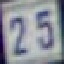

In [51]:
img

In [52]:
label

(2, 2, 5, 0, 0, 0)

In [68]:


class SVHNModel(torch.nn.Module):
    
    def _block(in_channels, out_channels, stride):
        """Helper to build CNN blocks."""
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=stride, padding=1),
            nn.Dropout(0.2)
        )

    def __init__(self):
        super().__init__()
        
        self.block1 = _block(in_channels=  3, out_channels= 48, stride=2)
        self.block2 = _block(in_channels= 48, out_channels= 64, stride=1)
        self.block3 = _block(in_channels= 64, out_channels=128, stride=2)
        self.block4 = _block(in_channels=128, out_channels=160, stride=1)
        self.block5 = _block(in_channels=160, out_channels=192, stride=2)
        self.block6 = _block(in_channels=192, out_channels=192, stride=1)
        self.block7 = _block(in_channels=192, out_channels=192, stride=2)
        self.block8 = _block(in_channels=192, out_channels=192, stride=1)
        self.fc1 = nn.Sequential(nn.Linear(192 * 7 * 7, 3072), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(3072, 3072), nn.ReLU())
        
        self.length = nn.Sequential(nn.Linear(3072, 7))
        self.digit1 = nn.Sequential(nn.Linear(3072, 11))
        self.digit2 = nn.Sequential(nn.Linear(3072, 11))
        self.digit3 = nn.Sequential(nn.Linear(3072, 11))
        self.digit4 = nn.Sequential(nn.Linear(3072, 11))
        self.digit5 = nn.Sequential(nn.Linear(3072, 11))
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = x.view(x.size(0), 192*7*7)
        x = self.fc1(x)
        x = self.fc2(x)

        length = self.length(x)  #  logits!
        digit1 = self.digit1(x)
        digit2 = self.digit2(x)
        digit3 = self.digit3(x)
        digit4 = self.digit4(x)
        digit5 = self.digit5(x)
        
        return length, digit1, digit2, digit3, digit4, digit5    

In [73]:
model = SVHNModel()
model.cuda()

SVHNModel(
  (block1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2)
  )
  (block2): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2)
  )
  (block4): Sequential(
    (0): Conv2d(

In [74]:
from torchsummary import summary

In [75]:
summary(model, input_size=(3, 54, 54))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 54, 54]           3,648
       BatchNorm2d-2           [-1, 48, 54, 54]              96
              ReLU-3           [-1, 48, 54, 54]               0
         MaxPool2d-4           [-1, 48, 28, 28]               0
           Dropout-5           [-1, 48, 28, 28]               0
            Conv2d-6           [-1, 64, 28, 28]          76,864
       BatchNorm2d-7           [-1, 64, 28, 28]             128
              ReLU-8           [-1, 64, 28, 28]               0
         MaxPool2d-9           [-1, 64, 29, 29]               0
          Dropout-10           [-1, 64, 29, 29]               0
           Conv2d-11          [-1, 128, 29, 29]         204,928
      BatchNorm2d-12          [-1, 128, 29, 29]             256
             ReLU-13          [-1, 128, 29, 29]               0
        MaxPool2d-14          [-1, 128,